In [1]:
import warnings
warnings.filterwarnings("ignore")

SEED = 1
N_IMG = 1

In [2]:
import random

import diffusers
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import torch

from src.diffusion_models import SDXLEditingPipeline
from src.llms import spot_objects
from src.detectors import OWLViTv2Detector

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Using DDPM as scheduler.


In [4]:
prompts = [
    "Two people enjoying hot dogs and soda pop.",
    "Two people walking under an umbrella on a street near some benches and a motorcycle.",
    "a woman in a blue top carrying two surfboards across a street",
    "A woman surfer riding on a crashing wave",
    "A man walking along a beach holding a surfboard"
]

In [5]:
generator = torch.Generator(device=device1).manual_seed(SEED)
out = base(prompt=[prompts[0]]*N_IMG, num_inference_steps=300, generator=generator, latents=None)

100%|██████████| 300/300 [00:37<00:00,  7.96it/s]


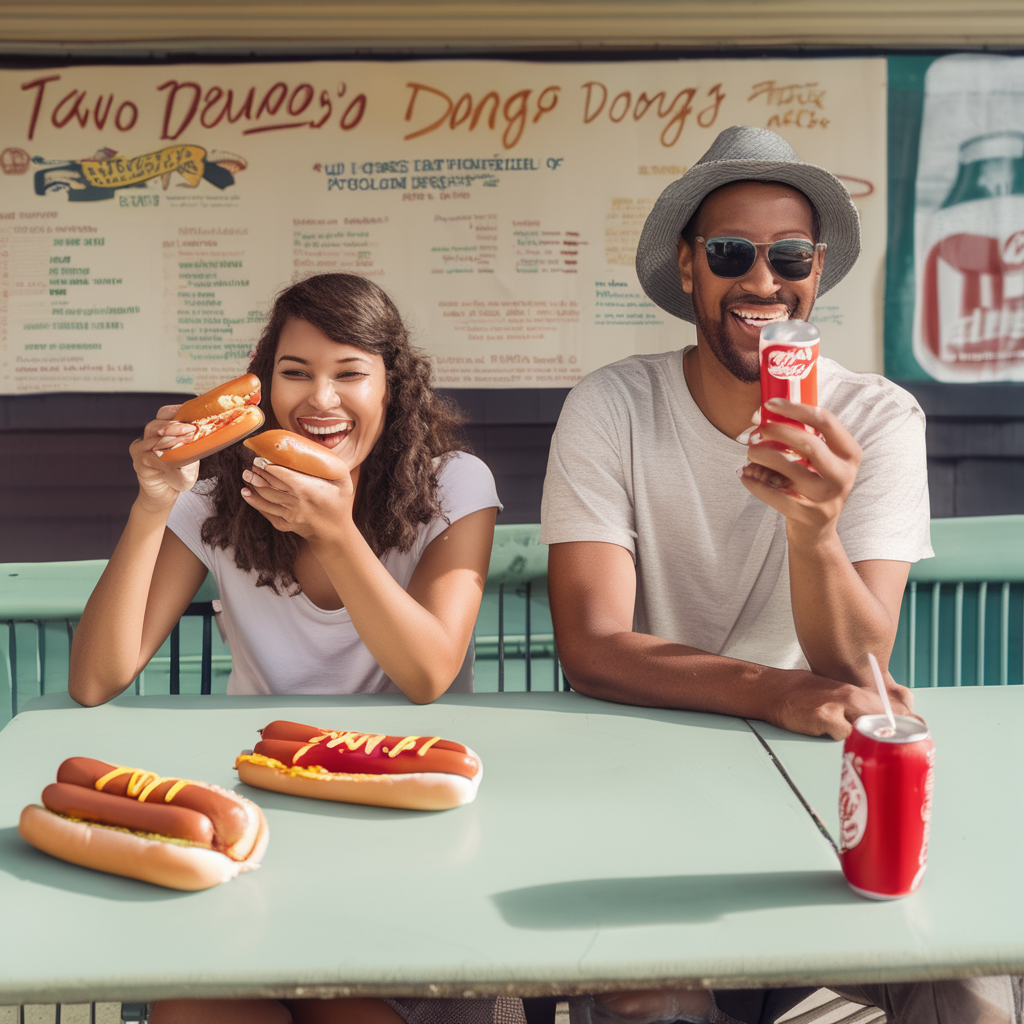

In [6]:
out.images[0]

In [9]:
import torch
from transformers import AutoModel, AutoTokenizer

# init model and tokenizer
model = AutoModel.from_pretrained('internlm/internlm-xcomposer2d5-7b', torch_dtype=torch.bfloat16, trust_remote_code=True).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained('internlm/internlm-xcomposer2d5-7b', trust_remote_code=True)
model.tokenizer = tokenizer

A new version of the following files was downloaded from https://huggingface.co/internlm/internlm-xcomposer2d5-7b:
- ixc_utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Set max length to 16384


Loading checkpoint shards: 100%|██████████| 3/3 [00:14<00:00,  4.80s/it]
A new version of the following files was downloaded from https://huggingface.co/internlm/internlm-xcomposer2d5-7b:
- tokenization_internlm2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [21]:
import torchvision
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scenes and their descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
1. Read the user prompt (scene description).
2. Identify all objects mentioned in the prompt and presented on the image with quantities.
3. Extract attributes of each object (color, size, material, etc.).
4. If the description mentions objects that shouldn't be in the image, take note at the negation part.
5. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
6. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples

- Example 1
    Image: **image**
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]
    Background: A realistic image
    Negation: 

- Example 2
    Image: **image**
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
    Background: A realistic image in a garage
    Negation: 

Your Current Task: Follow the steps closely and accurately identify objects based on the given image and prompt. Ensure adherence to the above output format.
"""

prompt = f"""{instruction}\Image: <ImageHere>\nUser Prompt: {prompts[0]}\n"""
# inputs = processor(prompt, images=None, return_tensors="pt").to(device)
# output = model.generate(**inputs,
#     max_new_tokens=1024,  # Increase max_new_tokens to allow longer generation
# )


# prompt_length = inputs['input_ids'].shape[1]
# generated_captions = processor.decode(output[0]).strip()

response, his = model.chat(tokenizer, prompt, [torchvision.transforms.functional.pil_to_tensor(out.images[0])], do_sample=False, num_beams=3, use_meta=True)

print(generated_captions[len(prompt):])

ValueError: not enough values to unpack (expected 4, got 3)

In [20]:
torchvision.transforms.functional.pil_to_tensor(out.images[0]).shape

torch.Size([3, 1024, 1024])

In [14]:
print(response)

Based on the given user prompt, "Two people enjoying hot dogs and soda pop," the process for identifying objects and their attributes would be as follows:

1. Read the user prompt (scene description).
2. Identify all objects mentioned with quantities:
   - Two people
   - Two hot dogs
   - Two soda pops
3. Extract attributes of each object (color, size, material, etc.):
   - People: No specific attributes mentioned.
   - Hot dogs: No specific attributes mentioned.
   - Soda pops: No specific attributes mentioned.
4. If the description mentions objects that shouldn't be in the image, take note at the negation part. In this case, there is no mention of objects that shouldn't be in the image.
5. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
6. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the 

In [7]:
from transformers import LlavaNextForConditionalGeneration, LlavaNextProcessor
from PIL import Image
import requests
import torch

processor = LlavaNextProcessor.from_pretrained("tiiuae/falcon-11B-vlm", tokenizer_class='PreTrainedTokenizerFast')
model = LlavaNextForConditionalGeneration.from_pretrained("tiiuae/falcon-11B-vlm", torch_dtype=torch.bfloat16)
model.eval()
device = torch.device("cuda:1")
model.to(device)

Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

In [34]:

instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene descriptions to identify objects and their attributes.

## Process Steps
1. Read the user prompt (scene description).
2. Identify all objects mentioned with quantities.
3. Extract attributes of each object (color, size, material, etc.).
4. If the description mentions objects that shouldn't be in the image, take note at the negation part.
5. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
6. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]
    Background: A realistic image
    Negation: 

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
    Background: A realistic image in a garage
    Negation: 

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Reasoning: Four objects are described: one car, airplane, two dog, and a chair. The chair is red color. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]
    Background: A realistic image
    Negation: 

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Reasoning: Here, there are five seagulls, one blue bicycle, one palm tree, and one bench. No specified negation terms. The background is an oil painting at the beach.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]
    Background: An oil painting at the beach
    Negation: 

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Reasoning: The description clearly states no backpacks, so this must be acknowledged. The user provides the negative prompt of backpacks. The background is an animated-style image.
    Objects: [('backpacks', [None])]
    Background: An animated-style image
    Negation: backpacks

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.
    Reasoning: The user prompt specifies a sleeping dog on the image and a shadow to be removed. The background is a realistic image of a grassland.                                                                                                                              
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]                                                                                                      
    Background: A realistic image of a grassland                                                                                                              
    Negation: shadows

Your Current Task: Follow the steps closely and accurately identify objects based on the given prompt. Ensure adherence to the above output format.
"""

prompt = f"""{instruction}\n User Prompt: {prompts[0]}\n"""
inputs = processor(prompt, images=None, return_tensors="pt").to(device)
output = model.generate(**inputs,
    max_new_tokens=1024,  # Increase max_new_tokens to allow longer generation
)


prompt_length = inputs['input_ids'].shape[1]
generated_captions = processor.decode(output[0]).strip()

print(generated_captions[len(prompt):])

 [('hot dogs', [None])]<|endoftext|>


In [31]:
processor

LlavaNextProcessor:
- image_processor: LlavaNextImageProcessor {
  "aspect_ratio_setting": "anyres",
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_grid_pinpoints": [
    [
      336,
      672
    ],
    [
      672,
      336
    ],
    [
      672,
      672
    ],
    [
      1008,
      336
    ],
    [
      336,
      1008
    ]
  ],
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "LlavaNextImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "LlavaNextProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

- tokenizer: PreTrainedTokenizerFast(name_or_path='tiiuae/falcon-11B-vlm', vocab_size=65024, model_max_length=2048, is_fast=True, padding_side='right', truncation_s

In [44]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
cats_image = Image.open(requests.get(url, stream=True).raw)
instruction = 'Write a long paragraph about this picture.'

prompt = f"""User:<image>\n{instruction} Falcon:"""
inputs = processor(prompt, images=cats_image, return_tensors="pt", padding=True).to(device)
output = model.generate(**inputs, max_new_tokens=256)

model_params = {"max_new+tokens": }
prompt_length = inputs['input_ids'].shape[1]
generated_captions = processor.decode(output[0], skip_special_tokens=True).strip()

print(generated_captions)

User:
Write a long paragraph about this picture. Falcon: The image features two cats lying on a pink blanket on a couch. One cat is positioned on the left side of the couch, while the other is on the right side. They are both sleeping peacefully, with one cat appearing to be a bit larger than the other.

There are two remote controls on the couch, one located near the left cat and the other near the right cat. The presence of the remotes suggests that the cats might be in a living room or a space where people watch television.


In [8]:
processor.tokenizer

PreTrainedTokenizerFast(name_or_path='tiiuae/falcon-11B-vlm', vocab_size=65024, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '>>TITLE<<', 'additional_special_tokens': ['<image>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken(">>TITLE<<", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken(">>ABSTRACT<<", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken(">>INTRODUCTION<<", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken(">>SUMMARY<<", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken(">>COMMENT<<", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken(">>ANSWER<<", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True)

In [12]:
model_params = {
    "max_new_tokens": 200,
}
tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it")
results = []
for prompt in prompts:
    result = spot_objects(processor.tokenizer, model, prompt, **model_params)
    results.append(result)

In [13]:
print(results[0])

Reasoning: The user prompt is about two people enjoying hot dogs and soda pop. The background is a realistic image. No specified negation terms.
    Objects: [('people', [None, None])]
    Background: A realistic image<|endoftext|>


In [11]:
detector = OWLViTv2Detector(device)

In [12]:
results_detection = detector(results[0]["objects"], out.images[0], device, 0.5, 0.3, 0.4)

TypeError: string indices must be integers, not 'str'

In [ ]:
from PIL import ImageDraw, ImageFont
width, height = out.images[0].size

img = out.images[0].copy()
draw = ImageDraw.Draw(img)
object_count = {}
for name, box_list in results_detection.items():
    for box in box_list:
        x1, y1, w, h = box
        x2 = x1 + w
        y2 = y1 + h
        x1 *= width
        x2 *= width
        y1 *= height
        y2 *= height
        draw.rectangle(((int(x1), int(y1)), (int(x2), int(y2))), outline=(255, 0, 0))
        font = ImageFont.load_default(size=20)
    
        text_size = draw.textbbox((0, 0), f"{name}, id={object_count.get(name, 0)}", font=font)
    
        text_position = (x1, max(y1 - text_size[3] - 2, 0))
        draw.text(text_position, f"{name}, id={object_count.get(name, 0)}", fill='white', font=font)
        object_count[name] = object_count.get(name, 0) + 1

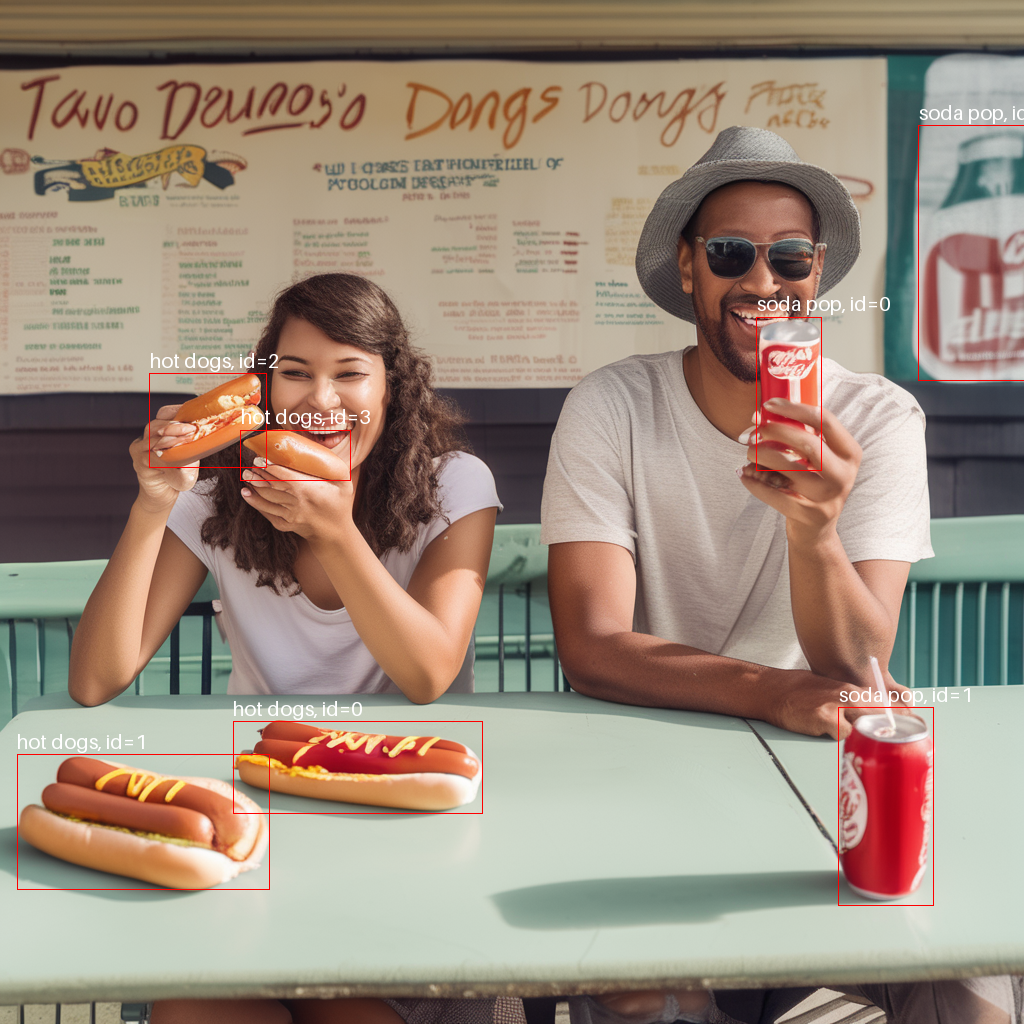

In [ ]:
img